# Getting started

In [6]:
from typing import TypedDict, Annotated, Union
from langgraph.graph import StateGraph, START, END
import random
from IPython.display import Image, display
import operator
from langchain_ollama import ChatOllama
import time 

* State - Input Schema for nodes and edges. Basically what the graph remembers
* Node - Basically functions. Each node operates on the state
* Edges - Connect the nodes. Can be conditional or direct

When you define a dictionary in python, on entering a wrong key there will be error during runtime.
TypedDict helps us define the expected structure of a dictionary. 

```
class User(TypedDict):
    name : str
    age : int

dict : User = {
    "name" : "Bruce",
    "age" : 45
}
```

Entering a wrong key like dict["time"] will be automatically flagged by a static type checker.

```
def get_value() -> User:
    return {"name" : "Alice", "age" : 18}
```

You can also use it while returning structured data to let the user know what kind of data is being returned.

# Basic Conditional Routing

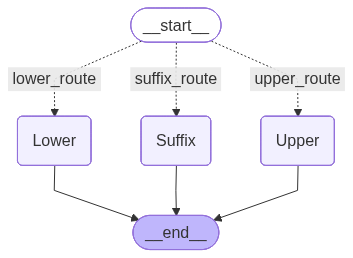

In [6]:
class BasicState(TypedDict): 
    content : str

def uppercase_node(state : BasicState):
    return {"content" : state["content"].upper()}

def lowercase_node(state : BasicState):
    return {"content" : state["content"].lower()}

def suffix_node(state : BasicState):
    return {"content" : state["content"] + "! -- END --"}

def route_random(state : BasicState): #Should return the string name of the next node - Basically randomly choosing which node to go next
    choices = ["upper_route", "lower_route", "suffix_route"]
    return random.choice(choices)

#initialize the graph 
builder = StateGraph(BasicState)

#Add the existing nodes to the graph
builder.add_node("Upper", uppercase_node)
builder.add_node("Lower", lowercase_node)
builder.add_node("Suffix", suffix_node)

#Adding the edges - along with our conditions
# (source_node, routing_function, path_map) -> Format

builder.add_conditional_edges(
    START,
    route_random,
    {
        "upper_route" : "Upper", #if routing function returns 'upper_route' then 'Upper' node is chosen
        "lower_route" : "Lower",
        "suffix_route" : "Suffix"
    }
)

#All nodes leading to the end in this scenario
builder.add_edge("Upper", END)
builder.add_edge("Lower", END)
builder.add_edge("Suffix", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

* The state doesn't just return a value it also stores it. Here the key "content", if any node updates "content" then langgraph automatically merges that into the state, overwriting it. If it was something like a list it would append into it so we can use like a message history. 

* In conditional edges, the path map dictionary keys are the names expected from the routing function. If it returns uppercase_route then the value in the routing map for this key should be the node that will be called for uppercase_route. The actual node names defined in builder.add_node

In [7]:
input_data = {"content" : "Hello . Testing ScripT" }

# invoke() -> Standard way to run the graph from start to end 

final_state = graph.invoke(input_data)
print(final_state)

{'content': 'Hello . Testing ScripT! -- END --'}


* While going through the docs for the langgraph I can see that it has a kind of immutability in the sense that every node which calls the state or updates the state, the variable being passed to the state is not modified.

* Every time any node updates the value of the state it can be accessed by other states. Not speaking about parallel, as of writing have to look into that.

* Each graph must _END_ 

* Each graph after _START_ goes into the routing logic

* .inovke() calls it synchronously

# Reducers

* By default Langgraph uses overwriting. 

* _Reducer_ is a function in Langgraph that tells it how to combine the old state with the new update. We can update, append, add and merge instead of just update and/or perform complex logic.

* _Union_ means a value can be of multiple types.

```
def func(param : Union[int, str]) -> None:

def func(para, : int | str) -> None:
````
Value can be either int or str 

* _Annotated_ can be referred to as " Type + Metadata "

```
x : Annotated[int, "Must be positive"]
```
Type is still int, just we have also specified metadata to help us later. Python by itself ignores it

```
from typing import Annotated 
from operator import add 

class State(TypedDict):
    messages : Annotated[list[str], add]
``` 

It tells langgraph that messages will contain a list of strings and when multiple nodes access it, it will combine the data (add)

* _Literal_ on the other hand is not about specifying what kind of data type is allowed but rather also exactly what values are allowed. 

``` 
from typing import Literal 

status : Literal["approved", "cancelled"]

def func(a) -> Literal["yes", "no"]
``` 

In [12]:
#This time a function that takes current values, updates it with new value and then returns it

def list_reducer(current : list, new : str) -> list:
    if current is None:
        return [new]
    result = current + [new]
    return result 

class BasicState(TypedDict): 
    content : str 
    history : Annotated[list[str], list_reducer] # history will contain a list of string and whenever history is updated Langgraph will call the reducer function

def uppercase_node(state : BasicState):
    new_content = state['content'].upper()
    return {"content" : new_content, "history" : new_content} 

def lowercase_node(state : BasicState):
    new_content = state['content'].lower()
    return {"content" : new_content, "history" : new_content}

def suffix_node(state : BasicState):
    new_content = state["content"] + "! -- END --" 
    return {"content" : new_content, "history" : new_content} 

'''
Use .add from operator to specify Langgraph that the new values will be added to the data type 

import operator 

class BasicState(TypedDict):
    content : str 
    history : Annotated[list[str], operator.add]
'''

'\nUse .add from operator to specify Langgraph that the new values will be added to the data type \n\nimport operator \n\nclass BasicState(TypedDict):\n    content : str \n    history : Annotated[list[str], operator.add]\n'

# Circular Graph

* Instead of all nodes leading to _END_, change edges such that they all lead back to the *Router* 

* State will pass through multiple nodes, Reducer will keep track of every transformation 

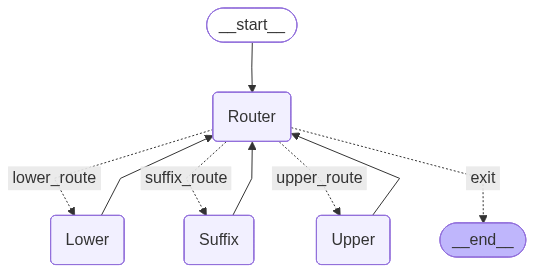

In [23]:
class BasicState(TypedDict): 
    content : str 
    history : Annotated[list[str], operator.add] 

def uppercase_node(state : BasicState):
    new_content = state['content'].upper()
    return {"content" : new_content, "history" : [new_content]} 

def lowercase_node(state : BasicState):
    new_content = state['content'].lower()
    return {"content" : new_content, "history" : [new_content]}

def suffix_node(state : BasicState):
    new_content = state["content"] + "! -- END --" 
    return {"content" : new_content, "history" : [new_content]} 

def route_random(state : BasicState): # Router Logic 
    if len(state.get('history', [])) >= 3:
        return 'exit'
    
    return random.choice(["upper_route", "lower_route", "suffix_route"])

def route_node(state : BasicState): #Does nothing, serves as a landing spot since you cannot go from an edge to START in langgraph
    return state

builder = StateGraph(BasicState)

builder.add_node("Upper", uppercase_node)
builder.add_node("Lower", lowercase_node)
builder.add_node("Suffix", suffix_node)
builder.add_node("Router", route_node)

builder.add_edge(START, "Router")

builder.add_conditional_edges(
    "Router", #We can start from any node of our choice tbh,
    route_random,
    {
        "upper_route": "Upper", 
        "lower_route" : "Lower",
        "suffix_route" : "Suffix",
        "exit" : END 
    }
)


builder.add_edge("Upper", "Router")
builder.add_edge("Lower", "Router")
builder.add_edge("Suffix", "Router")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
input_data = {"content" : "Hello, testing here",
              "history" : [] }

# invoke() -> Standard way to run the graph from start to end 

final_state = graph.invoke(input_data)
print(final_state)

{'content': 'HELLO, TESTING HERE', 'history': ['hello, testing here', 'hello, testing here', 'HELLO, TESTING HERE', 'hello, testing here', 'hello, testing here', 'HELLO, TESTING HERE']}


# Routing with LLM

In [14]:
model_id = "smollm2:135m"
llm = ChatOllama(model=model_id, temperature=0.9)

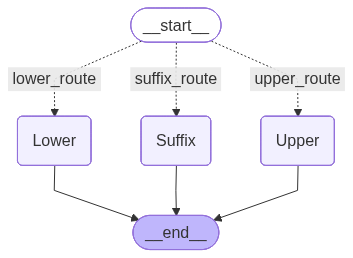

In [31]:
class BasicState(TypedDict): 
    content : str

def uppercase_node(state : BasicState):
    return {"content" : state["content"].upper()}

def lowercase_node(state : BasicState):
    return {"content" : state["content"].lower()}

def suffix_node(state : BasicState):
    return {"content" : state["content"] + "! -- END --"}

def route_llm(state : BasicState): #Should return the string name of the next node - Basically randomly choosing which node to go next
    content = state["content"]
    prompt = (
        f'''
        Analyze this text : "{content}". 
        "Randomly choose one of the strings from the given list :-
        ["upper_route", "lower_route", "suffix_route"] 
        Choose only one string from these 3 and do not return anything else in the textual response.
        So your response can be either 'upper_route' or 'lower_route' or 'suffix_route'. "
        ''' 
    )
    a = time.time()
    response = llm.invoke(prompt)
    choice = response.content.strip().lower() 
    #print(f"Time taken by {model_id} is {str(time.time()-a)} seconds")
    print(f"llm response is \n {choice}\n")

    #Fallbacks since model is very slow and not even thinking much about prompt
    if 'upper' in choice: return 'upper_route'
    if 'lower' in choice: return 'lower_route'
    if 'suffix' in choice: return 'suffix_route'

#initialize the graph 
builder = StateGraph(BasicState)

#Add the existing nodes to the graph
builder.add_node("Upper", uppercase_node)
builder.add_node("Lower", lowercase_node)
builder.add_node("Suffix", suffix_node)


builder.add_conditional_edges(
    START,
    route_llm,
    {
        "upper_route" : "Upper", #if routing function returns 'upper_route' then 'Upper' node is chosen
        "lower_route" : "Lower",
        "suffix_route" : "Suffix"
    }
)

#All nodes leading to the end in this scenario
builder.add_edge("Upper", END)
builder.add_edge("Lower", END)
builder.add_edge("Suffix", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
input_data = {"content" : "Hello . Testing ScripT" }
final_state = graph.invoke(input_data)
print(final_state)

llm response is 
 to analyze this text, i will follow these steps:

1. read through the text to understand what it is asking for. in this case, we want to identify which string from the given list does not return anything in our textual response.

2. based on that information, i will create a "random choice" function within my system to randomly select one of the strings from the given list and generate a text.

3. the generated string will be used as an input for the next question or answer we receive after the user's selected string is chosen.
4. after reading through the rest of the text, i will make sure that only "upper_route" or "lower_route" or "suffix_route" strings are returned from the algorithm and their responses return nothing in the textual response.

5. once i have verified all options, i can provide a default answer for my next question if there is an option unavailable to me, such as "random choice".
6. for example: if a user selects 'upper_route', my text would be: "u

Results not satisfactory in this level of model parameters and also no effort put into the prompt. Will work on this for actual use cases.